In [1]:
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import math
from math import radians, sin, cos, sqrt
import os
import geopandas as gpd
import psycopg2
import ast
import matplotlib.pyplot as plt
import datetime
from psycopg2 import sql
from psycopg2.extras import Json
from shapely.geometry import LineString, mapping, box, Polygon, Point
from shapely import wkt
from shapely.wkb import loads
import shapely
import json
from myutil import *
import scipy
import myutil
import pickle
import pyproj
from folium import plugins

from geopy.distance import great_circle
from scipy.spatial import KDTree, cKDTree
from sklearn.neighbors import NearestNeighbors
#from pykdtree.kdtree import KDTree
from sklearn.neighbors import BallTree
import sklearn.neighbors
import pykdtree
import rtree 
import pyqtree 
import quads
from quads import QuadTree
from pygeos import STRtree

d:\NewOne\UQ\INFS4205\assignment\taxi_trajectory\venv\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\Acer\AppData\Local\Temp\ipykernel_15228\3525318489.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https:

# Query: Find all data points (start point of other linestrings) within certain distance to a trajectory (start point of the given linestring) emerging on the same day.

Why did I change the query? Because each trip is considered independently, there's no interference during the taxi's movement. In other words, taxis will not stop to pick up additional passengers while in transit, so it is not necessary to check for other taxis while this taxi is in transit. (taxis are not buses)

Explain my approaches for this query:
- Approach 1: Find K-nearest neighbors within r (radius) distance (r is randomly selected, I don't know the exact number of r because it's not in meter or km, so the chosen r number is large enough in my experiment to cover these points). After that I use linear search to filter the distance as well as the timestamp (in the same day or not). I use KD-tree and Ball-tree radius_query for this approach.
- Approach 2: Find all points in a region (bounding box) that is calculated from the {target point} by adding and subtracting a {target distance}. Then, using linear scan to filter timestamp and distance again (because the bounding box is a rectangle, points at the corners of that are outside our distance). I use R-tree for this approach as a demonstration. (or we can use KD-tree or others same as task 1 query that I've done)
- For the performace comparison, I just compare performances in approach 1, and an example for R-tree approach 2, other approach-2 methods are not included in this task. The performances in region search have been showed in task 1

## Init

In [2]:
df = pd.read_csv("final_data.csv")

In [3]:
try:
    # connect to the database
    connection = psycopg2.connect(
    host="localhost",
    port="5432",
    dbname="taxi_trajectory",
    user="postgres",
    password="123456"
    )
    cursor = connection.cursor()
    print("Connected!")
except print(0):
    print("Connect error!")

Connected!


In [4]:
# close connection
if connection:
    cursor.close()
    connection.close()
    print("PostgreSQL connection is closed")

PostgreSQL connection is closed


In [ ]:
select_start_end_points_query = "SELECT trip_id, timestamp, start_long, start_lat, end_long, end_lat, geom FROM taxi_trips"
cursor.execute(select_start_end_points_query)
rows = cursor.fetchall()

Explain my query: Given a {trip_id}, find all the start_points within a distance {d} from the start point of that trip_id.

## Set up

In [ ]:
# Make sure that the trip_id is available.
distance_range = 50 # meter
distance_range_km = distance_range / 1000
target_trip_id = 1380586075620000431

In [ ]:
print(target_trip_id in set(df['trip_id']))

True


In [ ]:
target_timestamp = df[df['trip_id'] == target_trip_id]['timestamp'].values[0]
target_long = df[df['trip_id'] == target_trip_id]['start_long'].values[0]
target_lat = df[df['trip_id'] == target_trip_id]['start_lat'].values[0]
target_point = [[df[df['trip_id'] == target_trip_id]['start_long'].values[0], df[df['trip_id'] == target_trip_id]['start_lat'].values[0]]]
target_point_shapely = Point(target_long, target_lat)

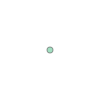

In [ ]:
target_point_shapely

In [ ]:
target_point

[[-8.640819, 41.160033]]

## DB query

Explain the steps of query:
1. Select start_point from taxi_trips by given trip_id as a target_point
2. Check is the point and target_point within a {distance} or not
3. Check are 2 points in the same day or not
4. The returned values except the {target_trip_id}

In [ ]:
# This query is good, but the problem is how to define the distance ? (It's not in meter in our case)
task3_query_db_2 = """ WITH target_point AS (
	SELECT trip_id, timestamp, ST_SetSRID(ST_MakePoint(start_long, start_lat), 4326) as point
    FROM taxi_trips
    WHERE trip_id = {}
)
SELECT trip_id, ST_DistanceSphere((SELECT point FROM target_point), ST_SetSRID(ST_MakePoint(start_long, start_lat), 4326)) as DistanceFromTargetPoint, timestamp, geom 
FROM taxi_trips
WHERE ST_DWITHIN(
	(SELECT point FROM target_point),
	ST_SetSRID(ST_MakePoint(start_long, start_lat), 4326),
	{}  -- This should be the distance in the spatial reference system (SRS) units. (Not meter)
)
AND date_trunc('day', to_timestamp(timestamp)) = (
    SELECT date_trunc('day', to_timestamp(timestamp))
    FROM target_point
)
AND trip_id != {};
""".format(target_trip_id, 0.00039, target_trip_id) # change the distance

In [ ]:
t1 = datetime.datetime.now()
cursor.execute(task3_query_db_2)
t2 = datetime.datetime.now()
print("Execution time: ", t2 - t1)
db_query_time_2 = t2 - t1
query3_result_db_2 = cursor.fetchall()
print(len(query3_result_db_2))

Execution time:  0:00:00.754088
18


In [ ]:
task3_query_db_1 = """ WITH target_point AS (
    SELECT trip_id, timestamp, ST_SetSRID(ST_MakePoint(start_long, start_lat), 4326) as point
    FROM taxi_trips
    WHERE trip_id = {}
)
SELECT trip_id, timestamp, ST_DistanceSphere((SELECT point FROM target_point), ST_SetSRID(ST_MakePoint(start_long, start_lat), 4326)) as DistanceFromTargetPoint--, geom 
FROM taxi_trips
WHERE ST_DistanceSphere((SELECT point FROM target_point), ST_SetSRID(ST_MakePoint(start_long, start_lat), 4326)) <= {} -- Distance in meters
AND date_trunc('day', to_timestamp(timestamp)) = (
    SELECT date_trunc('day', to_timestamp(timestamp))
    FROM target_point
)
AND trip_id != {};
""".format(target_trip_id, distance_range, target_trip_id) # distance in meter

In [ ]:
t1 = datetime.datetime.now()
cursor.execute(task3_query_db_1)
t2 = datetime.datetime.now()
print("Execution time: ", t2 - t1)
db_query_time_1 = t2 - t1
query3_result_db = cursor.fetchall()
print(len(query3_result_db))

Execution time:  0:00:00.874657
19


In [ ]:
list(query3_result_db)

[(1380558953620000410, 1380558953, 21.2954429),
 (1380557933620000001, 1380557933, 7.51603438),
 (1380564658620000577, 1380564658, 42.65911607),
 (1380564259620000634, 1380564259, 7.87438702),
 (1380565357620000148, 1380565357, 12.05509054),
 (1380627900620000251, 1380627900, 7.51603438),
 (1380606020620000189, 1380606020, 6.73386182),
 (1380608045620000503, 1380608045, 5.42678146),
 (1380635800620000359, 1380635800, 38.18442352),
 (1380555264620000254, 1380555264, 11.98964119),
 (1380554193620000432, 1380554193, 6.73386405),
 (1380555147620000410, 1380555147, 8.81490239),
 (1380556437620000065, 1380556437, 32.51079014),
 (1380559383620000352, 1380559383, 19.14823587),
 (1380617607620000128, 1380617607, 4.26590658),
 (1380615838620000324, 1380615838, 7.04569119),
 (1380618747620000436, 1380618747, 12.70233523),
 (1380620157620000380, 1380620157, 12.22011522),
 (1380622291620000346, 1380622291, 7.41589044)]

## KD-tree Scipy query (wrong result)

In [ ]:
points = []
timestamps = []
t1 = datetime.datetime.now()
for row in rows:
    trip_id, timestamp, start_long, start_lat, end_long, end_lat, geom_wkt = row
    points.append((start_long, start_lat, timestamp, trip_id))
    timestamps.append(timestamp)

points_array = np.array(points)
mykdtree = cKDTree(points_array[:, :2])
t2 = datetime.datetime.now()
print("Execution time", t2 - t1)
kdtree_scipy_creation_time = t2 - t1

Execution time 0:00:01.680507


In [ ]:
points_array[:, :2]

array([[-8.624556, 41.183811],
       [-8.685801, 41.164695],
       [-8.606457, 41.144607],
       ...,
       [-8.611119, 41.149467],
       [-8.628327, 41.157441],
       [-8.630478, 41.154471]])

In [ ]:
print(len(mykdtree.data[mykdtree.query_ball_point([target_long, target_lat], 0.0001)]))
print(mykdtree.data[mykdtree.query_ball_point([target_long, target_lat], 0.0001)])

1564
[[-8.640882 41.15997 ]
 [-8.6409   41.159979]
 [-8.640882 41.159961]
 ...
 [-8.640747 41.160096]
 [-8.640747 41.160096]
 [-8.640747 41.160096]]


In [ ]:
kdtree_scipy_indicies = mykdtree.query_ball_point([target_long, target_lat], 0.0001)

In [ ]:
retured_trip_ids_kdtree = []

for idx in kdtree_scipy_indicies:
    point_timestamp = int(timestamps[idx])
    point_daytime = datetime.datetime.fromtimestamp(point_timestamp).day
    
    if point_daytime ==  datetime.datetime.fromtimestamp(target_timestamp).day:
        retured_trip_ids_kdtree.append(int(points_array[idx][3]))  # Extract trip_id

print("Result Trip IDs:", retured_trip_ids_kdtree)

print("Total:", len(retured_trip_ids_kdtree))

Result Trip IDs: [1385821131620000512, 1383306523620000512, 1375303452620000256, 1385849647620000256, 1377963331620000256, 1380586075620000512, 1388520214620000512, 1377974594620000512, 1375303944620000000, 1380554193620000512, 1377966484620000256, 1388523471620000512, 1383252077620000000, 1378036798620000000, 1372685152620000000, 1375297997620000512, 1372670109620000512, 1385828195620000256, 1383251735620000256, 1377980656620000256, 1377970876620001024, 1380622291620000256, 1388584108620000256, 1375351638620000000, 1388521450620000000, 1388545480620000512, 1375309020620000000, 1383252185620000000, 1388527964620000256, 1388573946620000512, 1388561202620000512, 1378031010620000000, 1380617607620000256, 1388524419620000000, 1380608045620000512, 1388545685620000000, 1375298368620000256, 1391252767620000000, 1388520430620000768, 1388567319620000512, 1380557933620000000, 1380627900620000256, 1388505093620000000, 1383301986620000256, 1385846769620001024, 1380615838620000256, 1385905599620000

Wrong result.

## KD-tree Sklearn

I think this website is useful: https://sciencing.com/convert-latitude-longtitude-feet-2724.html
convert degree to meter

Multiply the degrees of separation of longitude and latitude by 111,139 to get the corresponding linear distances in meters.

In [ ]:
# KD-tree - SK learn 
t1 = datetime.datetime.now()
points = []
timestamps = []
for row in rows:
    trip_id, timestamp, start_long, start_lat, end_long, end_lat, geom_wkt = row
    #points.append((start_long, start_lat, timestamp, trip_id)) # 3D
    points.append((start_long, start_lat)) # 2D
    timestamps.append(timestamp)

mykdtree_sklearn = sklearn.neighbors.KDTree(points)
points_array = np.array(points)
t2 = datetime.datetime.now()
print("Execution time:", t2 - t1)
kdtree_sklearn_creation_time = t2 - t1

Execution time: 0:00:02.828413


In [ ]:
target_point = [[target_long, target_lat]]
distance_range_for_sklearn= 0.00039 # it's hard to select a correct number at the beginning. 
distance_range_km = distance_range / 1000
print("range:", distance_range_km, "km")
kdtree_sklearn_result = set()

t1 = datetime.datetime.now()
kdtree_sklearn_indices, kdtree_sklearn_distances = mykdtree_sklearn.query_radius(target_point, distance_range_for_sklearn, return_distance= True)

#print("total idicies:", len(kdtree_scipy_indicies))

for distance, index in zip(kdtree_sklearn_distances[0], kdtree_sklearn_indices[0]):
    trip_id = rows[index][0]  # Extract trip_id from the corresponding row
    timestamp = timestamps[index]  # Extract timestamp from the corresponding row
    distance_to_target_point = great_circle((rows[index][2], rows[index][3]), (target_long, target_lat))
    if (trip_id != target_trip_id):
        if (distance_to_target_point <= distance_range_km): #convert to km
            if (datetime.datetime.fromtimestamp(timestamp).date() == datetime.datetime.fromtimestamp(target_timestamp).date()):
                kdtree_sklearn_result.add(trip_id)
                #print("trip_id:", trip_id, "  dist:", distance_to_target_point)
                #print("distance from kdtree sklearn:", distance)
                
t2 = datetime.datetime.now()
print("Execution time", t2 - t1)
kdtree_sklearn_query_time = t2 - t1

range: 0.05 km
total idicies: 1564
Execution time 0:00:00.061834


In [ ]:
len(kdtree_sklearn_result)

18

In [ ]:
list(kdtree_sklearn_result)

[1380559383620000352,
 1380556437620000065,
 1380617607620000128,
 1380557933620000001,
 1380615838620000324,
 1380635800620000359,
 1380558953620000410,
 1380564259620000634,
 1380608045620000503,
 1380554193620000432,
 1380565357620000148,
 1380618747620000436,
 1380555147620000410,
 1380622291620000346,
 1380627900620000251,
 1380620157620000380,
 1380606020620000189,
 1380555264620000254]

In [ ]:
"""
from DB
[(1380558953620000410, 1380558953, 21.2954429),
 (1380557933620000001, 1380557933, 7.51603438),
 (1380564658620000577, 1380564658, 42.65911607),
 (1380564259620000634, 1380564259, 7.87438702),
 (1380565357620000148, 1380565357, 12.05509054),
 (1380627900620000251, 1380627900, 7.51603438),
 (1380606020620000189, 1380606020, 6.73386182),
 (1380608045620000503, 1380608045, 5.42678146),
 (1380635800620000359, 1380635800, 38.18442352),
 (1380555264620000254, 1380555264, 11.98964119),
 (1380554193620000432, 1380554193, 6.73386405),
 (1380555147620000410, 1380555147, 8.81490239),
 (1380556437620000065, 1380556437, 32.51079014),
 (1380559383620000352, 1380559383, 19.14823587),
 (1380617607620000128, 1380617607, 4.26590658),
 (1380615838620000324, 1380615838, 7.04569119),
 (1380618747620000436, 1380618747, 12.70233523),
 (1380620157620000380, 1380620157, 12.22011522),
 (1380622291620000346, 1380622291, 7.41589044)]
 
 From query #1 in DB script - (using ST_DWITHIN 0.00039 = 500 meters) 
 - actually, I don't know how to calculate this number
 - just base on my experiment
 1380558953620000410
1380557933620000001
1380564259620000634
1380565357620000148
1380606020620000189
1380608045620000503
1380627900620000251
1380617607620000128
1380615838620000324
1380618747620000436
1380620157620000380
1380622291620000346
1380555264620000254
1380554193620000432
1380555147620000410
1380556437620000065
1380559383620000352

 From KD-tree sklearn
 [1380559383620000352,
 1380556437620000065,
 1380617607620000128,
 1380557933620000001,
 1380615838620000324,
 1380635800620000359,
 1380558953620000410,
 1380564259620000634,
 1380608045620000503,
 1380554193620000432,
 1380565357620000148,
 1380618747620000436,
 1380555147620000410,
 1380622291620000346,
 1380627900620000251,
 1380620157620000380,
 1380606020620000189,
 1380555264620000254]
 
 """

## Ball-tree Sklearn

The implementation is same as KD-tree above

In [ ]:
# Ball-tree - SK learn
t1 = datetime.datetime.now()
points = []
timestamps = []
for row in rows:
    trip_id, timestamp, start_long, start_lat, end_long, end_lat, geom_wkt = row
    #points.append((start_long, start_lat, timestamp, trip_id)) # 3D
    points.append((start_long, start_lat)) # 2D
    timestamps.append(timestamp)

myballtree_sklearn = sklearn.neighbors.BallTree(points)
points_array = np.array(points)
t2 = datetime.datetime.now()
print("Execution time:", t2 - t1)
balltree_sklearn_creation_time = t2 - t1

Execution time: 0:00:02.383334


In [ ]:
target_point = [[target_long, target_lat]]
distance_range_for_sklearn= 0.00039 # it's hard to select a correct number at the beginning. 
distance_range_km = distance_range / 1000 # convert m to km
print("range:", distance_range_km, "km")
balltree_sklearn_result = set()

t1 = datetime.datetime.now()
balltree_sklearn_indices, balltree_sklearn_distances = myballtree_sklearn.query_radius(target_point, distance_range_for_sklearn, return_distance= True)

for distance, index in zip(balltree_sklearn_distances[0], balltree_sklearn_indices[0]):
    trip_id = rows[index][0]  # Extract trip_id from the corresponding row
    timestamp = timestamps[index]  # Extract timestamp from the corresponding row
    distance_to_target_point = great_circle((rows[index][2], rows[index][3]), (target_long, target_lat))
    if (trip_id != target_trip_id):
        if (distance_to_target_point <= distance_range_km): #convert to km
            if (datetime.datetime.fromtimestamp(timestamp).date() == datetime.datetime.fromtimestamp(target_timestamp).date()):
                balltree_sklearn_result.add(trip_id)
                
t2 = datetime.datetime.now()
print("Execution time", t2 - t1)
balltree_sklearn_query_time = t2 - t1

range: 0.05 km
Execution time 0:00:00.048869


In [ ]:
len(balltree_sklearn_result)

18

In [ ]:
list(balltree_sklearn_result)

[1380559383620000352,
 1380556437620000065,
 1380617607620000128,
 1380557933620000001,
 1380615838620000324,
 1380635800620000359,
 1380558953620000410,
 1380564259620000634,
 1380608045620000503,
 1380554193620000432,
 1380565357620000148,
 1380618747620000436,
 1380555147620000410,
 1380622291620000346,
 1380627900620000251,
 1380620157620000380,
 1380606020620000189,
 1380555264620000254]

## R-tree query

In [ ]:
def translate_latlong(lat, long, lat_translation_meters, long_translation_meters):
    ''' method to move any lat,long point by provided meters in lat and long direction.
    params :
        lat,long: lattitude and longitude in degrees as decimal values, e.g. 41.15554, -8.6348530
        lat_translation_meters: movement of point in meters in lattitude direction.
                                positive value: up move, negative value: down move
        long_translation_meters: movement of point in meters in longitude direction.
                                positive value: left move, negative value: right move
        '''
    earth_radius = 6378.137

    #Calculate top, which is lat_translation_meters above
    m_lat = (1 / ((2 * math.pi / 360) * earth_radius)) / 1000;  
    lat_new = lat + (lat_translation_meters * m_lat)

    #Calculate right, which is long_translation_meters right
    m_long = (1 / ((2 * math.pi / 360) * earth_radius)) / 1000;  # 1 meter in degree
    long_new = long + (long_translation_meters * m_long) / math.cos(lat * (math.pi / 180));
    
    return lat_new,long_new

In [381]:
lat_translation_meters = long_translation_meters = distance_range = 50 #meter
# Calculate new coordinates
x_plus, y_plus = translate_latlong(target_lat, target_long, lat_translation_meters, long_translation_meters)
x_minus, y_minus = translate_latlong(target_lat, target_long, -lat_translation_meters, -long_translation_meters)

# Output
print("X + 50 meters:", x_plus)
print("X - 50 meters:", x_minus)
print("Y + 50 meters:", y_plus)
print("Y - 50 meters:", y_minus)

X + 50 meters: 41.16048215764206
X - 50 meters: 41.15958384235794
Y + 50 meters: -8.64022240943679
Y - 50 meters: -8.641415590563211


In [338]:
# move up
x_minus_3, y_minus_3 = translate_latlong(target_lat, target_long, lat_translation_meters, 0)

In [374]:
# test
# top-right corner
print(great_circle((target_long, target_lat), (y_plus, x_plus)))
# bottom-left corner
print(great_circle((target_long, target_lat), (y_minus, x_minus)))
print(great_circle((target_long, target_lat), (y_minus_3, x_minus_3)))

0.0826972625514468 km
0.08269721590114308 km
0.49377235719869356 km


In [375]:
plot_point_and_bounding_box(target_long, target_lat, y_minus, x_minus, y_plus, x_plus)

In [341]:
# Create R-tree index
p = rtree.index.Property()
p.dimension = 2  # Three dimensions: x, y (bounding box) and timestamp
myrtree = rtree.index.Index(properties=p)

In [342]:
t1 = datetime.datetime.now()
for row in rows:
    trip_id, timestamp, start_long, start_lat, end_long, end_lat, geom_wkt = row
    myrtree.insert(int(trip_id), (start_long, start_lat, start_long, start_lat))
t2 = datetime.datetime.now()
print("Execution time", t2 - t1)
rtree_creation_time = t2 - t1 

Execution time 0:01:14.505482


In [376]:
query_bounds = (y_minus, x_minus, y_plus, x_plus)
t1 = datetime.datetime.now()
retured_trip_ids_rtree = myrtree.intersection(query_bounds)
t2 = datetime.datetime.now()
print("Execution time:", t2-t1)
rtree_query_time = t2 - t1
retured_trip_ids_rtree = list(retured_trip_ids_rtree)

Execution time: 0:00:00.003992


In [377]:
retured_trip_ids_rtree = list(retured_trip_ids_rtree)

filtered_trip_ids = set()
t1 = datetime.datetime.now()
for trip_id in retured_trip_ids_rtree:
    idx = df[df['trip_id'] == trip_id].index[0]
    point = (df['start_long'][idx], df['start_lat'][idx])
    timestamp = df['timestamp'][idx]
    if (trip_id != target_trip_id):
        if (great_circle(point, (target_long, target_lat)) <= distance_range_km):
            if (datetime.datetime.fromtimestamp(timestamp).date() == datetime.datetime.fromtimestamp(target_timestamp).date()):
                filtered_trip_ids.add(trip_id)
    
t2 = datetime.datetime.now()
print("Filtered results Execution time:", t2 - t1)
rtree_query_time += t2 - t1
print("Total query time:", rtree_query_time)

Filtered results Execution time: 0:00:05.800490
Total query time: 0:00:05.804482


In [379]:
len(filtered_trip_ids)

18

In [354]:
filtered_trip_ids

{1380554193620000432,
 1380555147620000410,
 1380555264620000254,
 1380556437620000065,
 1380557933620000001,
 1380558953620000410,
 1380559383620000352,
 1380564259620000634,
 1380565357620000148,
 1380606020620000189,
 1380608045620000503,
 1380615838620000324,
 1380617607620000128,
 1380618747620000436,
 1380620157620000380,
 1380622291620000346,
 1380627900620000251,
 1380635800620000359}

In [ ]:
""" It's correct
    From DB
    [(1380558953620000410, 1380558953, 21.2954429),
 (1380557933620000001, 1380557933, 7.51603438),
 (1380564658620000577, 1380564658, 42.65911607),
 (1380564259620000634, 1380564259, 7.87438702),
 (1380565357620000148, 1380565357, 12.05509054),
 (1380627900620000251, 1380627900, 7.51603438),
 (1380606020620000189, 1380606020, 6.73386182),
 (1380608045620000503, 1380608045, 5.42678146),
 (1380635800620000359, 1380635800, 38.18442352),
 (1380555264620000254, 1380555264, 11.98964119),
 (1380554193620000432, 1380554193, 6.73386405),
 (1380555147620000410, 1380555147, 8.81490239),
 (1380556437620000065, 1380556437, 32.51079014),
 (1380559383620000352, 1380559383, 19.14823587),
 (1380617607620000128, 1380617607, 4.26590658),
 (1380615838620000324, 1380615838, 7.04569119),
 (1380618747620000436, 1380618747, 12.70233523),
 (1380620157620000380, 1380620157, 12.22011522),
 (1380622291620000346, 1380622291, 7.41589044)]
    
    R-tree
    {1380554193620000432,
 1380555147620000410,
 1380555264620000254,
 1380556437620000065,
 1380557933620000001,
 1380558953620000410,
 1380559383620000352,
 1380564259620000634,
 1380565357620000148,
 1380606020620000189,
 1380608045620000503,
 1380615838620000324,
 1380617607620000128,
 1380618747620000436,
 1380620157620000380,
 1380622291620000346,
 1380627900620000251,
 1380635800620000359}
    """

## Linear scan (brute force)

(small talk) I don't like this technique, it's pretty... dumb :D

In [399]:
linear_scan_returned_ids = set()
t1 = datetime.datetime.now()
for row in rows:
    trip_id, timestamp, start_long, start_lat, end_long, end_lat, geom_wkt = row
    distance_to_target = great_circle((start_long, start_lat), (target_long, target_lat))                              
    if ((distance_to_target <= distance_range_km)
        and (datetime.datetime.fromtimestamp(timestamp).date() == datetime.datetime.fromtimestamp(target_timestamp).date())
        and (trip_id != target_trip_id)):
            linear_scan_returned_ids.add(trip_id)
            #print("distance:", distance_to_target)
t2 = datetime.datetime.now()
print("Execution time", t2 - t1)
linear_scan_query_time = t2 - t1


Execution time 0:00:11.554141


In [398]:
len(linear_scan_returned_ids)

18

In [401]:
linear_scan_returned_ids

{1380554193620000432,
 1380555147620000410,
 1380555264620000254,
 1380556437620000065,
 1380557933620000001,
 1380558953620000410,
 1380559383620000352,
 1380564259620000634,
 1380565357620000148,
 1380606020620000189,
 1380608045620000503,
 1380615838620000324,
 1380617607620000128,
 1380618747620000436,
 1380620157620000380,
 1380622291620000346,
 1380627900620000251,
 1380635800620000359}

# Compare performace

## Creation time

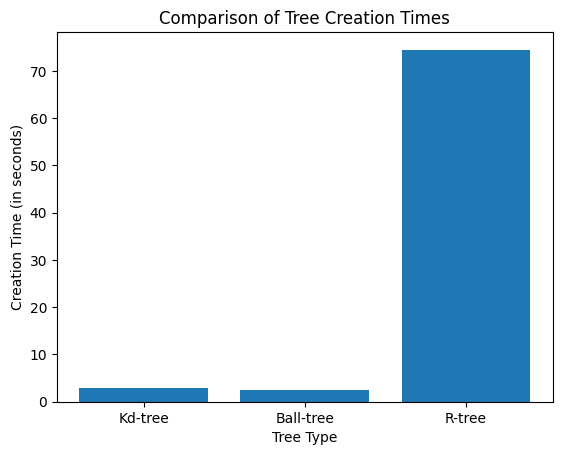

In [383]:
creation_time_all = {'Kd-tree': kdtree_sklearn_creation_time.total_seconds(), 
                     'Ball-tree': balltree_sklearn_creation_time.total_seconds(),
                     'R-tree': rtree_creation_time.total_seconds()}

plt.bar(creation_time_all.keys(), creation_time_all.values())
plt.xlabel('Tree Type')
plt.ylabel('Creation Time (in seconds)')
plt.title('Comparison of Tree Creation Times')
plt.show()

## Query time

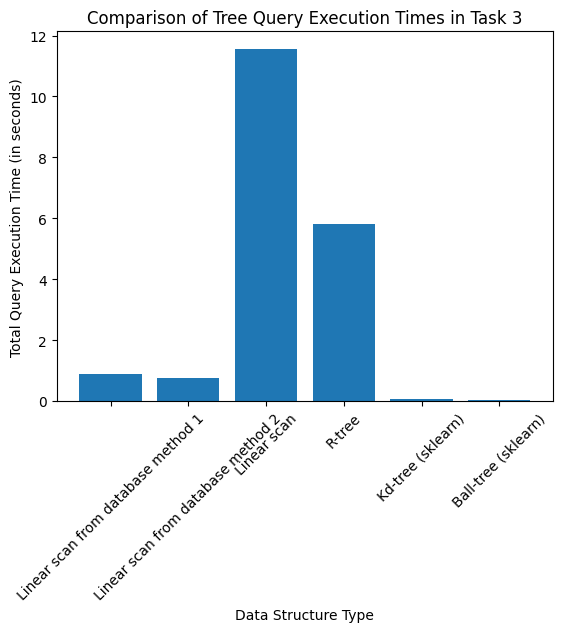

In [402]:
query_time_all = {'Linear scan from database method 1': db_query_time_1.total_seconds(),
                  'Linear scan from database method 2': db_query_time_2.total_seconds(),
                  'Linear scan': linear_scan_query_time.total_seconds(),
                  'R-tree': rtree_query_time.total_seconds(), 
                  'Kd-tree (sklearn)': kdtree_sklearn_query_time.total_seconds(), 
                  'Ball-tree (sklearn)': balltree_sklearn_query_time.total_seconds()}

plt.bar(query_time_all.keys(), query_time_all.values())

plt.xlabel('Data Structure Type')
plt.ylabel('Total Query Execution Time (in seconds)')
plt.title('Comparison of Tree Query Execution Times in Task 3')
plt.xticks(rotation=45)
plt.show()

Explaination: linear scan (from python) is much slower because there's no indexing technique applied (but DB has). R-tree seems not efficient in this case because it takes a lot of time to find the intersections. KD-tree and Ball-tree are both good, however, as I mentioned before, choosing the "radius r" at the beginning is also an issue to consider